In [92]:
from utils.utilities import get_engine
import pandas as pd
import numpy as np
from scipy.stats import norm
import math
from datetime import datetime, timedelta

In [93]:
engine = get_engine()

In [94]:
stock_codes = ['ACB', 'SSI', 'PMB', 'LSS']

In [95]:
day_interval = 365 # one year of transaction

In [96]:
end_date = datetime.today().date()
start_date = end_date - timedelta(days = day_interval)

In [97]:
# query all data of the stock code since the first transaction date
query = f"""
    SELECT 
        date,
        stock_code,
        close_price
    FROM public.transaction
    WHERE
        date >= DATE '{start_date}'
        AND
        date <= DATE '{end_date}'
        AND
        stock_code IN {tuple(stock_codes)}
    ORDER BY date
"""
df = pd.read_sql_query(query, engine).set_index('date')
df.head()

,stock_code,close_price
date,,
2020-09-15,POV,6.2000
2020-09-15,LSS,5.4300
2020-09-15,SSI,15.5014
2020-09-16,LSS,5.4700
2020-09-16,SSI,15.5995


In [98]:
# preprocess data
result = None
for stock_code in stock_codes:
    stock_prices = df[df['stock_code'] == stock_code].rename(columns = {'close_price' : stock_code})[stock_code].to_frame()
    if result is None:
        result = stock_prices
    else:
        result = result.merge(stock_prices, on = 'date')
df = result
df.head()

,ACB,SSI,POV,LSS
date,,,,
2020-12-14,22.56,24.6747,5.5,8.00
2020-12-15,22.40,25.0181,5.5,7.90
2020-12-22,23.00,29.0406,6.3,8.22
2020-12-25,22.36,29.7273,5.5,7.91
2020-12-28,22.24,31.3952,5.5,8.00


In [99]:
# Describe the stock in the last 100 days
df.iloc[:100].describe()

,ACB,SSI,POV,LSS
count,100.000000,100.000000,100.000000,100.000000
mean,28.044100,36.498053,7.697000,11.430700
std,4.305225,7.280755,0.890404,1.635015
min,21.320000,24.674700,5.500000,7.860000
25%,25.570000,32.388600,7.200000,10.275000
50%,27.000000,33.529100,7.800000,11.600000
75%,29.940000,38.091175,8.200000,12.850000
max,36.720000,55.000000,9.500000,14.300000


<AxesSubplot:title={'center':'daily percentage returns'}, xlabel='date'>

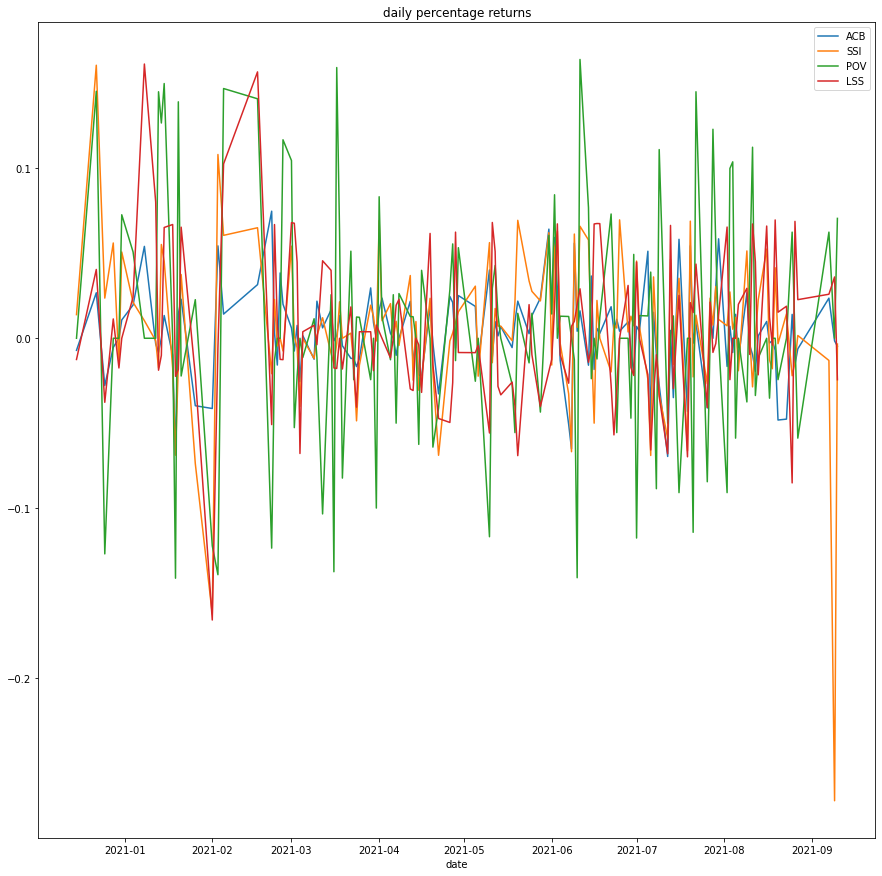

In [100]:
# Risk analysis
pct_change = df.pct_change().dropna()
pct_change.plot(figsize = (15,15), title = 'daily percentage returns')

<AxesSubplot:title={'center':'Portfolio Risk'}>

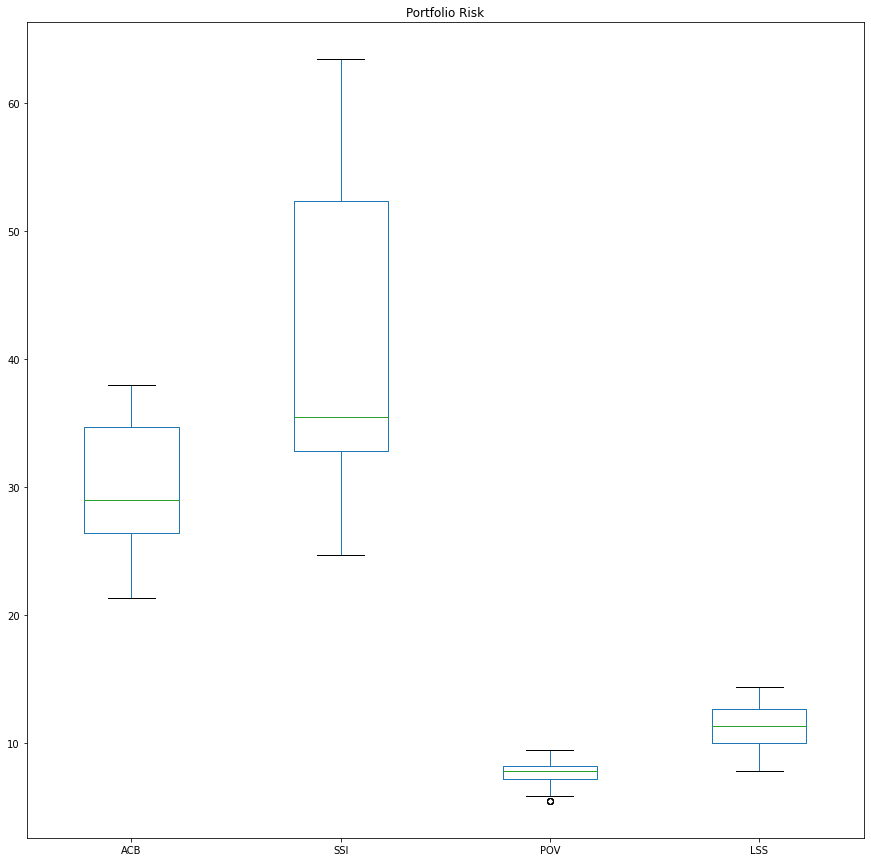

In [101]:
# Box plot to visually show risk
df.plot.box(figsize=(15, 15), title="Portfolio Risk")

In [102]:
# Calculate cumulative returns
cumulative_returns = (1 + pct_change).cumprod()

<AxesSubplot:title={'center':'Cumulative Returns'}, xlabel='date'>

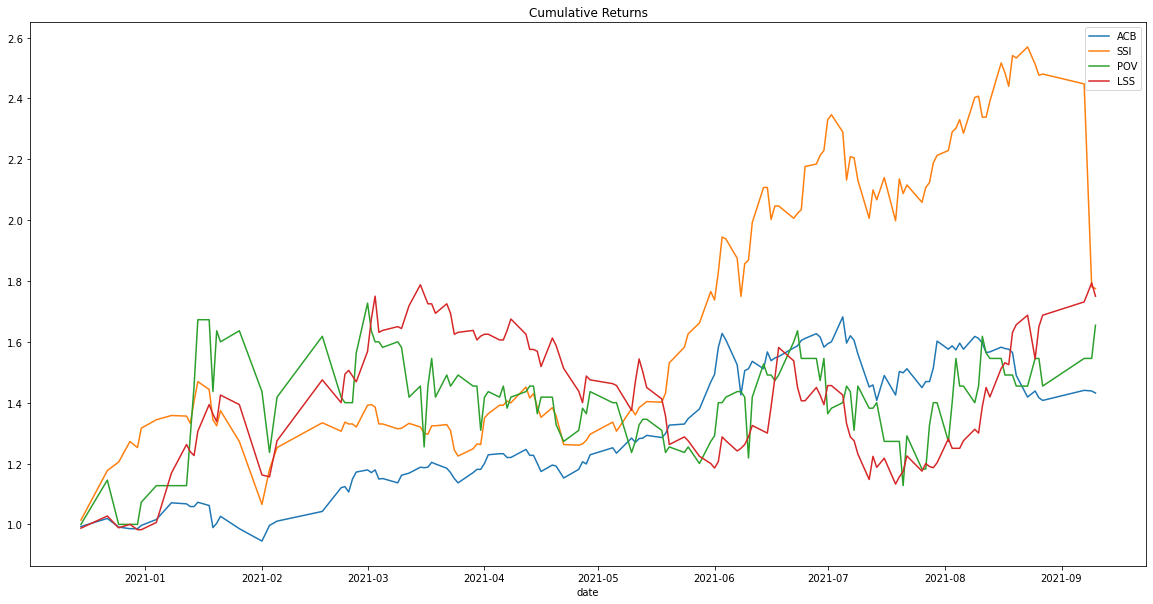

In [103]:
# Plot cumulative returns
cumulative_returns.plot(figsize=(20, 10), title="Cumulative Returns")

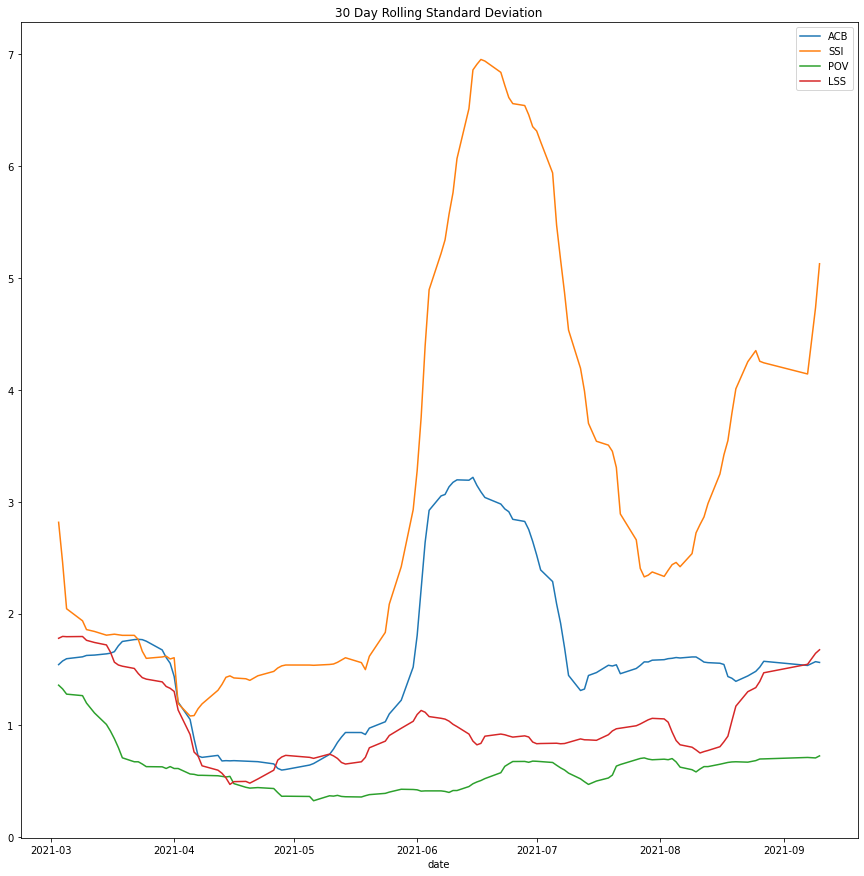

In [104]:
# rolling 30 day windows of volatility
df.rolling(window=30).std().plot(figsize=(15, 15), title="30 Day Rolling Standard Deviation");

In [105]:
# Get correlation between these stocks
df.corr()

,ACB,SSI,POV,LSS
ACB,1.000000,0.894384,0.208428,-0.054808
SSI,0.894384,1.000000,0.227518,-0.090199
POV,0.208428,0.227518,1.000000,0.603278
LSS,-0.054808,-0.090199,0.603278,1.000000


In [106]:
# get confidence interval of the stock
for stock_code in stock_codes:
    log_return = np.log(df[stock_code].shift(-1) - np.log(df[stock_code]))
    sample_size = len(log_return)
    sample_mean = log_return.mean()
    sample_std = log_return.std(ddof = 1) / (sample_size ** 0.5)
    # left and right quantile
    z_left = norm.ppf(0.05)
    z_right = norm.ppf(0.95)

    # upper and lower bound
    interval_left = sample_mean + z_left * sample_std
    interval_right = sample_mean + z_right * sample_std

    print(f"Confidence interval of daily return of {stock_code} is: ({round(interval_left * 1000,2)},{round(interval_right * 1000, 2)})VND")

Confidence interval of daily return of ACB is: (3242.0,3290.39)VND
Confidence interval of daily return of SSI is: (3578.31,3653.57)VND
Confidence interval of daily return of POV is: (1714.84,1751.74)VND
Confidence interval of daily return of LSS is: (2150.23,2197.12)VND
